In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import timm  # для визуальных моделей   
from transformers import GPT2Config, AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel

In [2]:
from transformers import T5ForConditionalGeneration, AutoTokenizer, AdamW
from torchvision import transforms
import torchvision

class VLMCaptioner(nn.Module):
    """
    Very simple: resnet50 (pretrained) -> linear projection -> T5 encoder (inputs_embeds)
    T5 does the decoding / loss calculation.
    proj_seq_len: how many 'image tokens' to create (1 is simplest).
    """
    def __init__(self, text_model_name='t5-small', proj_seq_len=1, freeze_cnn=True):
        super().__init__()
        # vision encoder
        self.cnn = torchvision.models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # remove classifier, now outputs 2048-d vector
        if freeze_cnn:
            for p in self.cnn.parameters():
                p.requires_grad = False
        
        # text model (T5)
        self.text_model = T5ForConditionalGeneration.from_pretrained(text_model_name)
        self.d_model = self.text_model.config.d_model
        
        # projection from 2048 -> d_model * proj_seq_len
        self.proj_seq_len = proj_seq_len
        self.proj = nn.Linear(2048, self.d_model * proj_seq_len)
    
    def forward(self, images, labels=None):
        """
        images: (B, C, H, W)
        labels: (B, L) with -100 for padding
        """
        feats = self.cnn(images)                      # (B, 2048)
        proj = self.proj(feats)                       # (B, d_model * seq_len)
        proj = proj.view(-1, self.proj_seq_len, self.d_model)  # (B, seq_len, d_model)
        
        # run T5 encoder with inputs_embeds
        encoder_outputs = self.text_model.encoder(
            inputs_embeds=proj,
            return_dict=True
        )
        # pass encoder_outputs to T5ForConditionalGeneration; it will do decoding + loss if labels set
        outputs = self.text_model(
            encoder_outputs=encoder_outputs,
            labels=labels,
            return_dict=True
        )
        return outputs  # contains loss, logits, etc.
    
    @torch.no_grad()
    def generate(self, images, tokenizer, max_length=32, num_beams=3, device='cpu'):
        feats = self.cnn(images.to(device))
        proj = self.proj(feats).view(-1, self.proj_seq_len, self.d_model)
        encoder_outputs = self.text_model.encoder(inputs_embeds=proj, return_dict=True)
        generated_ids = self.text_model.generate(
            encoder_outputs=encoder_outputs,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
            decoder_start_token_id=tokenizer.pad_token_id,
        )
        return [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]


In [3]:
class VLMDataset(Dataset):
    def __init__(self, images, texts, transform=None, tokenizer=None, max_length=128):
        self.images = images
        self.texts = texts
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        
        if self.transform:
            image = self.transform(image)
        
        text = self.texts[idx]
        
        if self.tokenizer:
            text_encoded = self.tokenizer(
                text, 
                max_length=self.max_length, 
                padding='max_length', 
                truncation=True, 
                return_tensors='pt',
                add_special_tokens=True
            )
            input_ids = text_encoded['input_ids'].squeeze()
            attention_mask = text_encoded['attention_mask'].squeeze()
            
            labels = input_ids.clone()
            labels[labels == self.tokenizer.pad_token_id] = -100
        else:
            input_ids, attention_mask, labels = text, None, text
        
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'text': text
        }

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16  # Меньше batch size из-за большей памяти
# learning_rate = 5e-5
num_epochs = 5

In [5]:
# Трансформы
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.pad_token = tokenizer.eos_token

In [7]:
from datasets import load_dataset
dataset = load_dataset("Naveengo/flickr8k")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8091
    })
})


In [8]:
from tqdm import tqdm

images = []
texts = []

for item in tqdm(dataset['train']):
    images.append(item['image'])
    texts.append(item['text'])

print(f"Загружено {len(images)} изображений")

100%|██████████| 8091/8091 [00:17<00:00, 462.57it/s]

Загружено 8091 изображений


In [9]:
dataset = VLMDataset(images, texts, transform, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
from torch import optim

# Модель
model = VLMCaptioner(text_model_name='t5-small', proj_seq_len=16, freeze_cnn=True)
model = model.to(device)

for name, param in model.cnn.named_parameters():
    # размораживаем только layer4
    if name.startswith("layer4"):
        param.requires_grad = True
    else:
        param.requires_grad = False

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
cnn_params = [p for n,p in model.cnn.named_parameters() if p.requires_grad]
text_params = [p for n,p in model.text_model.named_parameters() if p.requires_grad]
proj_params = [p for n,p in model.named_parameters() if "proj" in n or "spatial_pool" in n]

optimizer = AdamW([
    {'params': cnn_params, 'lr': 1e-5},       # small lr for CNN
    {'params': proj_params, 'lr': 5e-5},      # proj layer
    {'params': text_params, 'lr': 5e-5}       # T5 params (если разморажены)
])

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
model.train()
for epoch in range(num_epochs):  # поставил 3 для примера
    total_loss = 0.0
    for batch in tqdm(dataloader):
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        out = model(imgs, labels=labels)
        loss = out.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss/len(dataloader):.4f}")

100%|██████████| 506/506 [03:01<00:00,  2.79it/s]


Epoch 1 loss: 3.1600


100%|██████████| 506/506 [03:09<00:00,  2.68it/s]


Epoch 2 loss: 2.8154


100%|██████████| 506/506 [03:11<00:00,  2.64it/s]


Epoch 3 loss: 2.6840


100%|██████████| 506/506 [03:11<00:00,  2.64it/s]


Epoch 4 loss: 2.5956


100%|██████████| 506/506 [03:12<00:00,  2.63it/s]

Epoch 5 loss: 2.5311


# inference

In [ ]:
# torch.save(model.state_dict(), "vlm_captioner_old.pth")

In [ ]:
# model_new = VLMCaptioner(
#     lm_name="gpt2",
#     vision_model_name="vit_base_patch16_224",
#     vision_embed_dim=768,
#     lm_embed_dim=768
# ).to(device)

In [ ]:
# state = torch.load("vlm_captioner_old.pth", map_location=device)
# model_new.load_state_dict(state)

In [18]:
@torch.no_grad()
def generate_caption(image_tensor, model, tokenizer, device='cuda', 
                                 max_length=32, num_beams=3):
    """
    image_tensor: (C,H,W) или (B,C,H,W) после transform (включая normalize)
    model: VLMCaptioner
    tokenizer: T5 tokenizer
    """

    model.eval()

    # Если один объект — добавляем batch dim
    if image_tensor.ndim == 3:
        image_tensor = image_tensor.unsqueeze(0)

    image_tensor = image_tensor.to(device)

    # --- CNN → projection → T5 encoder ---
    feats = model.cnn(image_tensor)
    proj = model.proj(feats).view(-1, model.proj_seq_len, model.d_model)

    encoder_outputs = model.text_model.encoder(
        inputs_embeds=proj,
        return_dict=True
    )

    # --- Decode ---
    generated_ids = model.text_model.generate(
        encoder_outputs=encoder_outputs,
        num_beams=num_beams,
        max_length=max_length,
        early_stopping=True
    )

    captions = [
        tokenizer.decode(ids, skip_special_tokens=True)
        for ids in generated_ids
    ]

    return captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].


A man riding his bike on a hill .


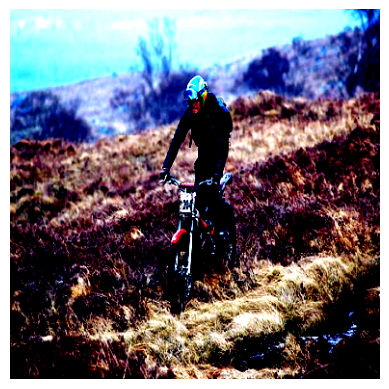

In [35]:
import matplotlib.pyplot as plt

ind = 458
img = dataset[ind]['image']

# Преобразуем (3, 224, 224) -> (224, 224, 3)
img = img.permute(1, 2, 0)
print(dataset[ind]['text'])
plt.imshow(img)
plt.axis('off')  # отключить оси
plt.show()

In [36]:
image = dataset[ind]['image'].to(device)

caption = generate_caption(image, model, tokenizer, max_length=32)
print(caption)

['A man in a black jacket is riding a bike on a mountain. a man in a black jacket is riding a bike']


In [21]:
img = Image.open('avatar.jpg')
img = transform(img)
generate_caption(img, model, tokenizer, max_length=128)

['A man in a blue shirt and a blue shirt is standing on a tree. a black and white tan tree is surrounded by flowers. a black and white tan tree is surrounded by flowers.']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


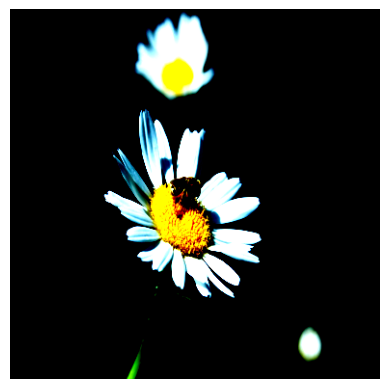

In [24]:
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.axis('off')  # отключить оси
plt.show()